# ประเด็นศึกษา  

เนื่องจากในช่วง 2 เดือนที่ผ่านมากระแสข่าวเรื่องฝุ่น pm 2.5 เป็นประเด็นที่ถูกนำมานำเสนออย่างมาก  
แต่ในหลายๆแหล่งกับตั้งหัวเรื่องที่บอกสาเหตุของปัญหาฝุ่นที่ต่างออกไป  

จากภาพด้านล่างแสดงให้เห็นถึงสำนักข่าว โพสต์ูเดย์ระบุว่าในหัวข้อข่าวโดยตีความได้ว่า อุณหภูมิที่เย็นลงทำให้ฝุ่นเพิ่มขึ้น

In [1]:
from IPython.display import IFrame
IFrame('https://www.posttoday.com/social/local/538980', width=500, height=400)

โจทย์ของกลุ่มเราคือ อุณหภูมิที่เย็นลงทำให้ฝุ่นเพิ่มขึ้น จริงตามที่หัวข่าวบอกหรือไม่

# Import modules ต่างๆ

```python 
import pandas as pd #จัดการข้อมูลประเภท data frames
```
```python 
import numpy as np #จัดการข้อมูลในรูปแบบ array หลายมิติ ตัด out liers
```
```python 
import matplotlib #เป็นส่วนการแสดงผลในรูปแบบ visualization เพื่อ plot กราฟ
```
```python 
import matplotlib.pyplot #เป็นส่วนการแสดงผลในรูปแบบ visualization เพื่อ plot กราฟ
```
```python 
import seaborn #ใช้ในการ plot กราฟ
```
```python 
from scipy import stats #ใช้งานฟังก์ชันทางสถิติ
```
```python
%matplotlib inline #ทำให้ matplotlib แสดงบน jupyter notebook ได้
```
```python 
%config InlineBackend.figure_format = 'retina' #เพื่อให้การแสดงผลของกราฟ แบบความละเอียดสูง
```
```python
import ipywidgets as widgets #สร้ง widget
```

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker
from scipy import stats
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import ipywidgets as widgets

In [3]:
print(f'pandas version : {pd.__version__}')
print(f'seaborn version : {sns.__version__}')

pandas version : 1.2.1
seaborn version : 0.11.1


In [4]:
pd.Timestamp.now()

Timestamp('2021-04-25 00:43:56.545048')

# กำหนด url ที่มาของข้อมูล  

โดยไฟล์ข้อมูลค่า  
   - PM 2.5 นำมาจาก berkeleyearth โดยวัดที่ศาลาว่าการกรุงเทพ  
   - สภาพอากาศ นำมาจาก https://www.wunderground.com/ โดยวัดที่โรงเรียนสาธิตจุฬาลงกรณ์มหาวิทยาลัย  

เพื่อง่ายต่อการทำงานจึงได้นำข้อมูลไปเก็บไว้ใน github

In [20]:
url_weather = 'https://raw.githubusercontent.com/korpong-si/propk/master/PM2.5/weather_pm25.csv'

In [6]:
url_pm = 'http://berkeleyearth.lbl.gov/air-quality/maps/cities/Thailand/Bangkok/Bangkok.txt'

# ข้อมูลสภาพอากาศ

#### สร้าง dataframe จาก url_pm

In [7]:
df_weather = pd.read_csv(url_weather, sep=',',parse_dates = [0])

#### ลบ column 'Precip. Accum.' ออก

In [8]:
df_weather = df_weather.drop(columns = 'Precip. Accum.')

#### เอา column ที่มีค่า NA ออก

In [9]:
df_weather.dropna(inplace = True)

#### กำหนดให้ column 'Date' เป็น index

In [10]:
df_weather.set_index('Date', inplace = True)

#### แปลงหน่วย

In [11]:
df_weather['Temperature Avg (C)'] = ((df_weather['Temperature Avg (F)']-32)*5/9).round(2)
df_weather['Dew Point Avg (C)'] = ((df_weather['Dew Point Avg (F)']-32)*5/9).round(2)
df_weather['Wind Speed Avg (kmph)'] = (df_weather['Speed Avg (mph)'] * 1.60934).round(2)
df_weather['Pressure Avg (in)'] = df_weather['Pressure avg (in)']

In [12]:
df_weather = df_weather.drop(columns = ['Temperature Avg (F)',
                                        'Dew Point Avg (F)',
                                        'Speed Avg (mph)',
                                        'Pressure avg (in)'])

#### สลับตำแหน่ง columns

In [13]:
df_weather = df_weather.reindex(columns = ['Temperature Avg (C)',
                                           'Dew Point Avg (C)',
                                           'Wind Speed Avg (kmph)',
                                           'Humidity Avg (%)',
                                           'Pressure Avg (in)'])

#### box plot ก่อน clean ข้อมูล

Temperature Avg (C)         AxesSubplot(0.125,0.125;0.133621x0.755)
Dew Point Avg (C)        AxesSubplot(0.285345,0.125;0.133621x0.755)
Wind Speed Avg (kmph)     AxesSubplot(0.44569,0.125;0.133621x0.755)
Humidity Avg (%)         AxesSubplot(0.606034,0.125;0.133621x0.755)
Pressure Avg (in)        AxesSubplot(0.766379,0.125;0.133621x0.755)
dtype: object

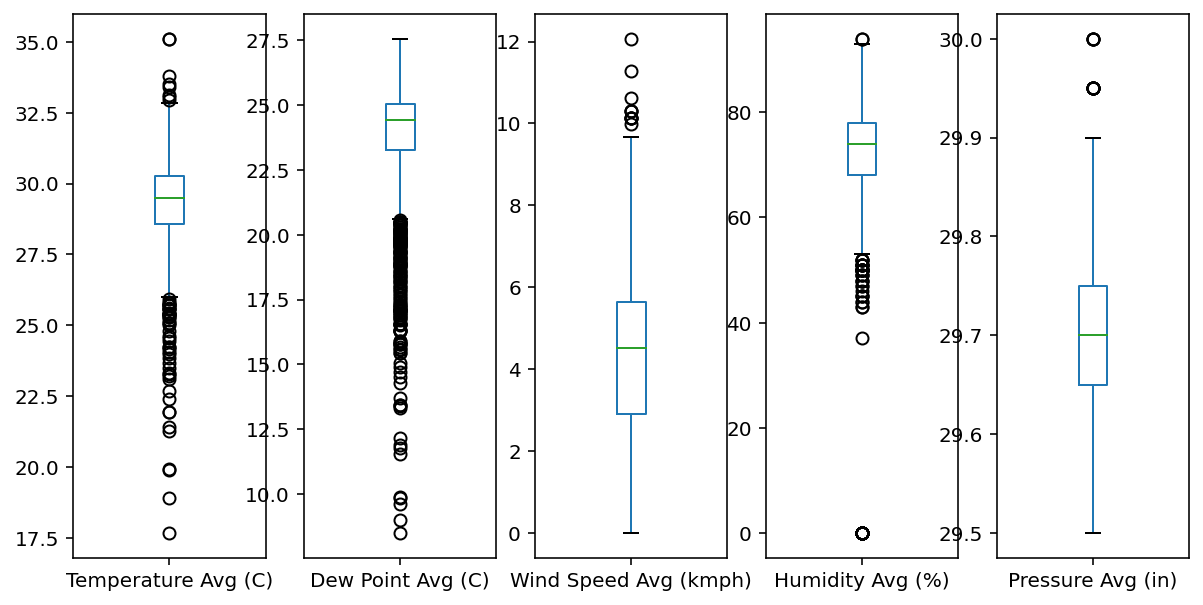

In [14]:
df_weather.plot(kind = 'box',subplots = True, figsize = (10,5))

#### clean ข้อมูลด้วยวิธี IQR 'interquartile range'

In [15]:
Q1 = df_weather.quantile(0.25)
Q3 = df_weather.quantile(0.75)
IQR = Q3 - Q1

In [16]:
df_weather_clean = df_weather[~((df_weather < (Q1 -  3 * IQR)) |(df_weather > (Q3 + 3 * IQR))).any(axis=1)]

#### box plot หลัง clean ข้อมูลแล้ว

Temperature Avg (C)         AxesSubplot(0.125,0.125;0.133621x0.755)
Dew Point Avg (C)        AxesSubplot(0.285345,0.125;0.133621x0.755)
Wind Speed Avg (kmph)     AxesSubplot(0.44569,0.125;0.133621x0.755)
Humidity Avg (%)         AxesSubplot(0.606034,0.125;0.133621x0.755)
Pressure Avg (in)        AxesSubplot(0.766379,0.125;0.133621x0.755)
dtype: object

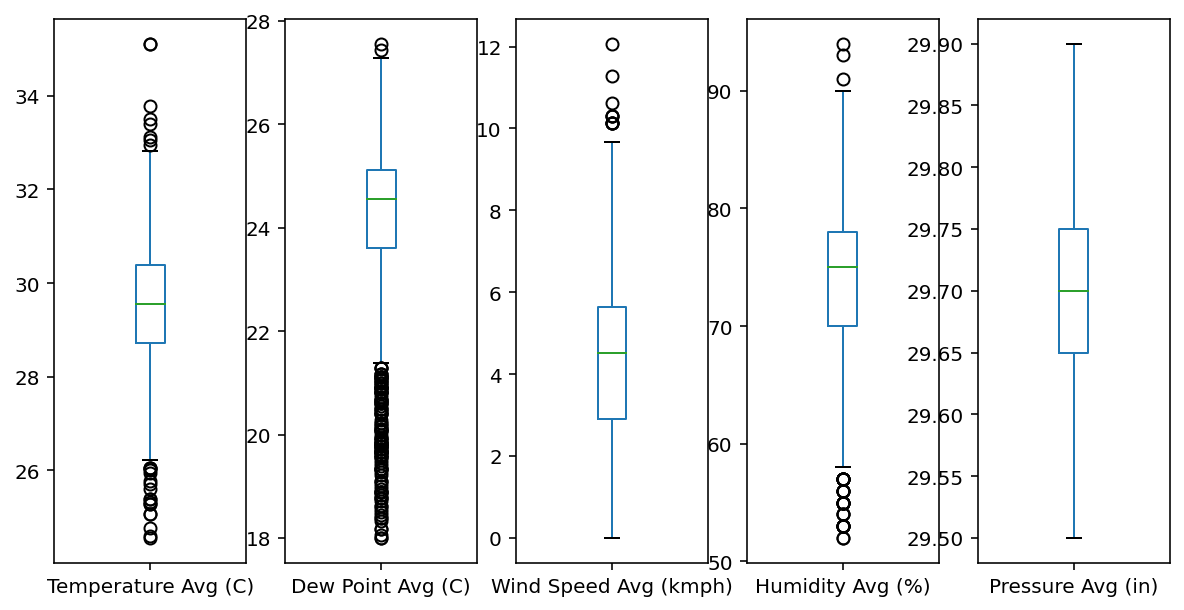

In [17]:
df_weather_clean.plot(kind = 'box',subplots = True, figsize = (10,5))

#### ข้อมูล weather ที่ clean แล้ว

In [18]:
df_weather_clean

,Temperature Avg (C),Dew Point Avg (C),Wind Speed Avg (kmph),Humidity Avg (%),Pressure Avg (in)
Date,,,,,
2016-01-01,28.00,18.78,5.95,58,29.90
2016-01-02,27.83,18.89,3.22,59,29.90
2016-01-03,28.56,18.72,2.90,56,29.90
2016-01-04,29.39,19.06,3.54,55,29.80
2016-01-05,29.89,18.94,4.18,54,29.80
...,...,...,...,...,...
2019-11-29,29.56,21.06,0.00,61,29.85
2019-11-30,30.28,22.06,0.00,62,29.80
2019-01-12,30.78,22.83,0.00,63,29.75


# ข้อมูลฝุ่น pm2.5

#### สร้าง dataframe จาก url_pm

In [ ]:
col_names = list('Year, Month, Day, Hour, PM2.5, PM10_mask, Retrospective'.split(', '))
df_pm = pd.read_csv(url_pm, sep = '\t', skiprows = 10, names = col_names)

#### ลบ column 'PM10_mask','Retrospective' ออก

In [ ]:
df_pm = df_pm.drop(columns = ['PM10_mask','Retrospective'])

#### สร้าง column ชื่อ Datetime และแปลง column เวลาให้เป็นเวลาประเทศไทย (UTC+7)
#### และการใช้ ฟังก์ชั่น to_datetime และ to_timedelta ทำให้เวลาที่ +7 ชั่วโมงแล้วเกิน 24 จะปัดไปเป็นวันถัดไป

In [ ]:
df_pm['Datetime'] = pd.to_datetime(df_pm[['Year','Month','Day','Hour']]) + pd.to_timedelta(7, unit ='h')

#### ลบ column 'Year','Month','Day','Hour' ออก

In [ ]:
df_pm = df_pm.drop(columns = ['Year','Month','Day','Hour'])

#### เอา column ที่มีค่า NA ออก

In [ ]:
df_pm.dropna(inplace = True)

#### กำหนดให้ column 'Date' เป็น index

In [ ]:
df_pm.set_index('Datetime', inplace = True)

#### หาค่า mean ของรายวัน และ ปัดให้เหลือทศนิยม 2 หลัก

In [ ]:
df_pm = df_pm.resample('D').mean().round(2)

#### box plot ก่อน clean ข้อมูล

In [ ]:
df_pm.plot(kind = 'box',subplots = True, figsize = (10,5))

#### clean ข้อมูลด้วยวิธี IQR 'interquartile range'

In [ ]:
Q1 = df_pm.quantile(0.376)
Q3 = df_pm.quantile(0.75)
IQR = Q3 - Q1

In [ ]:
df_pm_clean = df_pm[~((df_pm < (Q1 - 1.5 * IQR)) |(df_pm > (Q3 + 1.5 * IQR))).any(axis=1)]

#### box plot หลัง clean ข้อมูลแล้ว

In [ ]:
df_pm_clean.plot(kind = 'box',subplots = True, figsize = (10,5))

#### ข้อมูล pm2.5 ที่ clean แล้ว

In [ ]:
df_pm_clean.head()

# MERGE DATAFRAME

รวม 2 dataframe ด้วยคำสั่ง merge โดยให้ merge ด้วย column Datetime แบบ inner join

In [ ]:
df_result = pd.merge(df_pm_clean, df_weather_clean, left_index= True, right_index= True, how = 'inner')

#### เปลี่ยนชื่อ column เป็น PM25

In [ ]:
df_result.rename(columns = {'PM2.5' : 'PM25'}, inplace = True)

In [ ]:
df_result.head()

#### เนื่องจากการหา regression จะมี column ที่ไม่มีค่า (NA) จึงต้องนำค่า Na ออก

In [ ]:
df_result.dropna(inplace = True)

In [ ]:
df_result.head()

# Widgets แสดง join plot ตาม variable ที่สนใจ

In [ ]:
vari =widgets.Dropdown(
    options= ['Temperature Avg (C)',
              'Dew Point Avg (C)',
              'Wind Speed Avg (kmph)',
              'Humidity Avg (%)',
              'Pressure Avg (in)'],
    value='Temperature Avg (C)',
    description='variable : ',
    disabled=False,
)
display(vari)

In [ ]:
sns.jointplot(x = vari.value , y = 'PM25', data = df_result, kind = 'reg')

จากกราฟข้างต้น แสดงให้เห็นถึงการกระจายตัวของข้อมูล เส้นregression และ confident interval 

# หาค่า correlation

correlation เป็นตัวเลข ที่บอกถึง ความสัมพันธ์ของสองตัวแปร เช่น ความสัมพันธ์ระหว่าง X และ Y มีค่าเป็นเท่าไหร โดยมี range อยู่ที่ -1 ถึง 1

#### สร้างตาราง correlation table เพื่อดูความสัมพันธ์ของตัวแปรแต่ละตัวแปร

In [ ]:
result_corr = df_result.corr()

In [ ]:
result_corr

#### สร้าง correlation matrix เพื่อ visualize

In [ ]:
cmap = sns.diverging_palette(h_neg = 0, h_pos = 120, as_cmap = True) 

#### สร้าง np.array ที่สมาชิกทุกตัวมีค่าเป็น 0 และมีขนาดเท่ากับ result_corr   
#### จากนั้นน mask สามเหลี่ยมบน(tri-upper)ของ array mask ให้มีค่าเป็น 1

In [ ]:
mask=np.zeros_like(df_result.corr())
mask[np.triu_indices_from(mask)] = True

In [ ]:
mask

In [ ]:
plt.figure(figsize = (10,5))
sns.heatmap(df_result.corr(), 
            mask=mask, 
            annot=True, 
            linewidths=.5, 
            vmin = -1, 
            vmax = 1, 
            cmap = cmap, 
            fmt = '.2f', 
            square = True, 
            center = 0 )

จะเห็นได้ว่า ค่า correlation ของ อุณหภูมิ Temperature Avg (C) กับ ค่า PM2.5 มีค่าเท่ากับ 0.015509  

ตีความได้ว่า "สองตัวแปรไม่มีความสัมพันธ์กัน" เนื่องจากตกใน range -0.3 ถึง 0.3: No correlation  

เมื่อตีความเพิ่มเติมจะเห็นได้ว่า  

ปัจจัยต่างๆที่ มีความสัมพันธ์กับ PM2.5 ดังนี้  

-0.3 ถึง 0.3: No correlation      Temperature Avg (C)    Wind Speed Avg (kmph)  

-0.69 ถึง -0.31: Weak Negative    Dew Point Avg (C)      Humidity Avg (%)  

0.31 ถึง 0.69 : Weak Positive     Pressure Avg (in)


# Multiple regression

### หา regression

ศึกษาเพิ่มเติมว่าปัญจัยคู่ใดมีผลส่งเสริมกันเพื่อให้อุณหภูมิมีผลกับค่า pm2.5

In [ ]:
import statsmodels.api as sm

In [ ]:
x=df_result['PM25']
y=df_result[['Temperature Avg (C)','Dew Point Avg (C)']]
model_TD = sm.OLS(x,y).fit()
print(model_TD.summary())

# สรุป

จากการตั้งสมมติฐานให้ ตัวแปรPM2.5 กับ ตัวแปรอุณหภูมิ มีความสัมพันธ์กัน
เมื่อดูจากผลการวิเคราะห์ จะพบว่าค่า p-value(P>|t|) ของตัวแปรอุณหภูมิ กับ ตัวแปรPM2.5 มีค่าน้อยกว่าค่าความเชื่อมั่นที่ 99%0(significant level = 0.01)
คือ 0.00 < 0.01 (ทั้ง Temperature Avg (C) และ Dew Point Avg (C))
ซึ่ง สามารถอธิบายได้ว่ามีหลักฐานเพียงพอที่จะปฎิเสธสมมติฐานที่ว่า ตัวแปรPM2.5 กับ ตัวแปรอุณหภูมิมีความสัมพันธ์กัน 

ดังนั้น จากการศึกษาข้างต้น จึงพบว่า อุณหภูมิ ไม่ได้เป็นประเด็นที่จะส่งผลต่อค่าฝุ่น PM2.5 ดังที่ข่าวรายงานในหัวข้อข่าว